# Init and Confg Cell
loadig necessary libraries and setting the parameters for the Data Generation

In [46]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *

import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
periode = 2 #days
step = 5 # mess interval in minutes
val = 500
n_channels = 1
n_samples = 500
bs=50
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.02,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":0,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate one long MTS (one year)

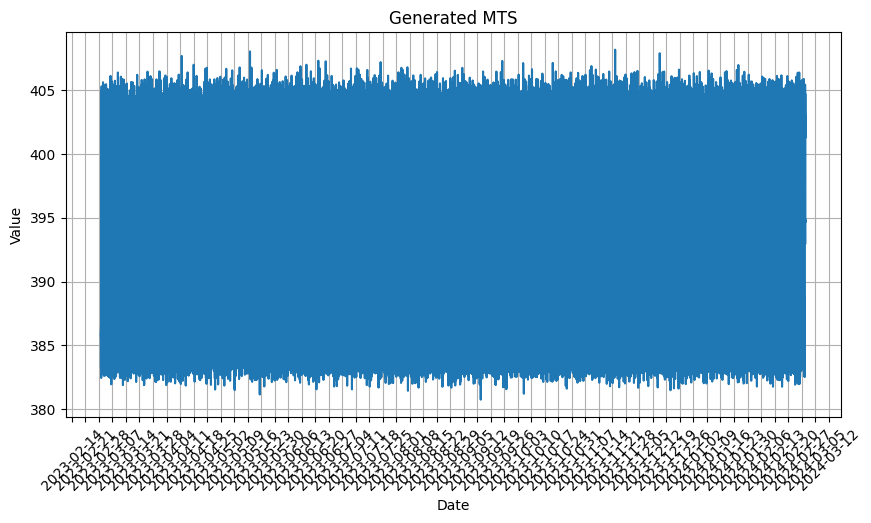

In [17]:
train_data_long, val_data_long, test_data_long = generate_long_data(effects, effect="Seasonality")

### Generate n=5000 MTS with the same effect
This Dataset represents **Pairs of MTS and their respective Labels** where the labels are the specefic parameters for each Time Series

generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


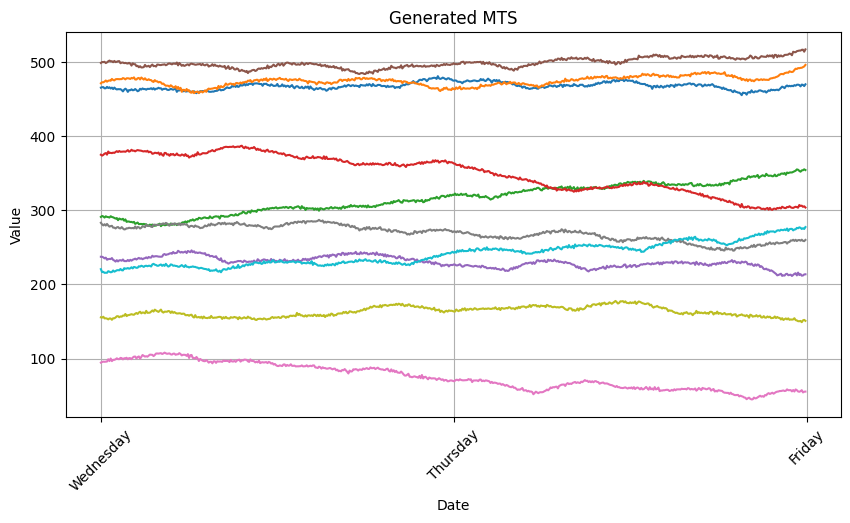

torch.Size([5000, 3])
tensor([[        0.,         0.,       456.],
        [        1.,         0.,       459.],
        [        2.,         0.,       280.],
        ...,
        [     4997.,         0.,       220.],
        [     4998.,         0.,        57.],
        [     4999.,         0.,       126.]])


In [47]:
train_data, val_data, test_data = generate_labeled_data(effects, batch_size=40, periode=periode, effect="both", occurance=5)

In [276]:
class Descriminator(nn.Module):
    def __init__(self, input_size=1, num_layers=1, latent_dims=10, L=576, slope=0.2, first_kernel=30, modified=False):
        super(Descriminator, self).__init__()

        self.n = self.lin_size(L, num_layers, first_kernel)
#         print("the outputed n is", self.n)
        self.cnn_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        
        self.n_channels = input_size
        self.L = L
        self.num_layers = num_layers
        self.latent_dims = latent_dims
        self.modified = modified
        
        lin_divider = 1024

        if self.modified:
            self.lin_input = self.n // (2 * self.num_layers)
        else:
            self.lin_input = self.n * self.n_channels
#         print("the n is: ", self.n)
#         print("the lin input is: ", self.lin_input)

        def init_weights(m):
            if isinstance(m, nn.Conv1d):
                torch.nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="leaky_relu")
                m.bias.data.fill_(0.01)

        # CNN Layers that double the channels each time
        for i in range(0, num_layers):
            if i == 0:
                if first_kernel == None: first_kernel = 2
                self.cnn_layers.append(
                    nn.Conv1d(input_size, input_size * 2, kernel_size=first_kernel, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size * 2))
            else:
                self.cnn_layers.append(
                    nn.Conv1d(input_size * 2 * i, input_size * 2 * (i + 1), kernel_size=2, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size * 2 * (i + 1)))
                
#         print(self.lin_input)
        while self.lin_input // lin_divider > 1:
            print(self.lin_input)
            self.linear_layers.append( nn.Linear(self.lin_input, self.lin_input // lin_divider))
            self.linear_layers.append( nn.LeakyReLU(slope, True)) 
            
            self.lin_input = self.lin_input // lin_divider
        
        self.linear_layers.append( nn.Linear(self.lin_input, 1))
        self.linear_layers.append( nn.Sigmoid())
        

    def forward(self, x):
        for i, cnn in enumerate(self.cnn_layers):
#             print("Desc Cnn", x.shape)
            x = cnn(x)
        cnn_shape = x.shape
#         print("Desc after Cnn ", x.shape)
        if not self.modified:
            x = x.view(x.size(0), -1)
#         print("Desc after review ", x.shape)
        
        for i, lin in enumerate(self.linear_layers):
#             print("Desc lin", x.shape)
            x = lin(x)

        return x
    def lin_size(self, n, num_layers, first_kernel=None):
        for i in range(0, num_layers):
#             print(n)
#             print(first_kernel)

            if i == 0 and first_kernel != None:
                n = 1 + ((n - first_kernel) // 2)
            else:
                n = 1 + ((n - 2) // 2)
#             print(n)
#         print("The calculated n is ", n)
        if n <= 0:
            raise ValueError("Window Length is too small in relation to the number of Layers")

        return n * 2 * num_layers
    
class Descriminator_linear(nn.Module):
    def __init__(self, n_channels=1, num_layers=1, L=576, slope=0.2):
        super(Descriminator_linear, self).__init__()

        self.model = nn.ModuleList()
        lin_input = L//5 + L%5

        # Linear Layers 
        for i in range(0, num_layers):
            self.model.append(nn.Linear(lin_input, lin_input*2))
            self.model.append(nn.LeakyReLU(slope, True))
            lin_input = 2 * lin_input
        self.model.append(nn.Linear(lin_input, 1))
        self.model.append(nn.Sigmoid())   
        
        self.init_weights()

    def forward(self, x):
        for layer in self.model:
#             print("Desc Cnn", x.shape)
            x = layer(x)
        return x
    
    def init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
                nn.init.constant_(m.bias, 0)

# Model Init Cell

model type/parameters are specified in the cell below

In [293]:
from importlib import reload
# reload(RnnEncoder)
# reload(RnnDecoder)
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
### Init Model
latent_dims = 20 # 6 # 17
L= 576 # train_data.dataset.n #2016# 39 #32
device = 'cuda' if torch.cuda.is_available() else 'cpu'


v = Variational_Autoencoder(n_channels = n_channels,
                            num_layers = 4,#4, #3
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            L=L,
                            slope = 0,
                            first_kernel = 252, #11, #20
                            ß = 1.5,
                            modified=False,
                            reduction = True)
# v = VQ_MST_VAE(n_channels = n_channels,
#                             num_layers =  3,#4, #3
#                             latent_dims= latent_dims,
#                             v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                             v_quantizer = VQ_Quantizer,
#                             L=L,
#                             slope = 0,
#                             first_kernel = 500, #11, #20
#                             commit_loss = 1.5,
#                             modified=True,
#                             reduction = True) #10 5
# v = VQ_MST_VAE(n_channels = n_channels,
#                             num_layers =  4,#4, #3
#                             latent_dims= latent_dims,
#                             v_encoder = RnnEncoder, #RnnEncoder, # LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = RnnDecoder, #RnnDecoder, # LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                             v_quantizer = VQ_Quantizer,
#                             L=L,
#                             slope = 0,
#                             first_kernel = 1008, #11, #20
#                             commit_loss = 1.5,
#                             modified=True,
#                             reduction = True) #10 5


v = v.to(device)

encoder = v.encoder
opt_enc = optim.Adam(encoder.parameters(), lr=0.0001)

decoder = v.decoder
opt_dec = optim.Adam(decoder.parameters(), lr=0.0001)

opt = optim.Adam(v.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945
print(v)

Variational_Autoencoder(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(1, 2, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(2, 4, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(4, 6, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Conv1d(6, 8, kernel_size=(2,), stride=(2,))
        (10): LeakyReLU(negative_slope=0, inplace=True)
        (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Linear(in_featu

In [284]:
netD = Descriminator()
netD = netD.to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
print(netD)

Descriminator(
  (cnn_layers): ModuleList(
    (0): Conv1d(1, 2, kernel_size=(30,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=548, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [252]:
from IPython import display
def rebuild_TS(model, train_loader, batch_size):
    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

    data_shape = train_loader.dataset.data.shape
    
    e_indices = torch.empty((data_shape[-1] - model._L) * 6)
#     print(e_indices.shape)
    Origin = torch.empty(data_shape)
    REC = torch.empty(data_shape)
#     print("data shape is. ", data_shape)
#     print("REC shape", REC.shape)
    
    idx = 0
    for sample_idx, (data, label, norm) in enumerate(train_loader):
#         print(data.device)
#         print(model.device)
        
        data = data.to(device) 
        norm = norm.to(device)
        bs   = data.shape[0]
#         print(norm.shape)
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        
        disc_real = netD(data)
        disc_fake = netD(x_rec)
#         print("Quantizer Output shape: ", e.shape)
#         print("model output in each bach", x_rec.shape)
#         print("What we take", x_rec[..., 0].T.shape)
#         print("Where we save it", REC[:, idx: idx+bs].shape)
#         print("The index we save at", idx)
#         print("\n\n")
#         print("the model indices output: ", indices.squeeze().shape)
#         print("our target shape is: ", e_indices[idx: idx+bs].shape)
        e_indices[idx*6: (idx+bs)*6] = indices.squeeze()
        Origin[..., idx: idx+bs] = (norm * data)[..., 0].T
        REC[..., idx: idx+bs] = (norm * x_rec)[..., 0].T        
        idx += bs
        
        if bs != batch_size:            
#             print("---------Final batch--------")
#             print("The index we save at", idx)
#             print("the rest of e_indices: ", e_indices[idx:].shape)
#             print("e_indices shape: ", e_indices.shape)
#             print("We take the full last sample", x_rec[-1].shape)
#             print("We fill the rest of REC", REC[:, idx:].shape)
#             e_indices[idx:] = indices.squeeze()
            Origin[..., idx:] = (norm*data)[-1]
            REC[..., idx:] = (norm*x_rec)[-1]
    return Origin, REC, e_indices
        
        
        
        
#         REC[:, ]
        
def train_on_sample(model, desc, train_loader, criterion, optimizer, optimizerD, device, epoch):
    model.to(device)
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    desc.to(device)
    desc.train()
    for p in desc.parameters():
        p.requires_grad = True
    sample_loss = 0
    D_losses = []
    VQ_losses = []
    eps = 1e-10

    for sample_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device) 
        label = label[:,:,1].to(device)
        norm = norm.to(device)

#         print(data.shape)
#         print(label.shape)
#         print(norm.shape)

        data_loader = DataLoader(slidingWindow((data*norm).squeeze(0), L=model._L), # slidingWindow, stridedWindow
                            batch_size= 50,# 59, # 22
                            shuffle = False
                            )
        
        loss = 0
        for sample_epoch in range(25):
            if sample_idx < 50:
                loss = train(model, data_loader, criterion, opt, device, sample_epoch, VQ = True)
            else:
                loss = tune(model, data_loader, criterion, opt_enc, device, sample_epoch, VQ = True)

        display.clear_output(wait=True)
        Origin, REC, indices = rebuild_TS(model, data_loader, 50)
#         Origin = (data*norm)[0].cpu()
        print(sample_idx)
        plot_rec(Origin.T.cpu(), REC.T.cpu())
        codebook = model.quantizer._embedding.weight
        heatmap = create_heatmap(codebook.cpu().detach().numpy() )
        plot_indices(indices)
        
        print(REC[:,:20])
        
        if sample_idx % 10 == 0:
            print("--------new Samples------------")
            print('Sample Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t True Loss: {:.6f}'.format(
                epoch, sample_idx, len(train_loader),
                       100. * sample_idx / len(train_loader), loss / len(data), loss))
#         D_losses.append(errD.item())
        VQ_losses.append(loss)
        
    print('====> Sample: {} Average loss: {:.4f}'.format(epoch, loss / len(train_loader.dataset)))

In [221]:
def plot_heatmap(ax_heatmap, codebook):
    ax_heatmap.clear()
    heatmap = ax_heatmap.imshow(codebook)
    ax_heatmap.set_title('Codebook Heatmap')
    ax_heatmap


    return heatmap
def create_heatmap(codebook):
    fig, ax_heatmap = plt.subplots(figsize=(12, 6), dpi=100)
    heatmap = plot_heatmap(ax_heatmap, codebook.T)
#     heatmap_canvas = FigureCanvasTkAgg(fig, master=heatmap_frame)
#     heatmap_canvas.draw()
#     heatmap_canvas.get_tk_widget().pack(fill="both", expand=True)
    cbar = fig.colorbar(heatmap)
    ax_heatmap.set_xlabel('Num of Embeddings')
    ax_heatmap.set_ylabel('Latent Dimensions')
    plt.show()
    
    return ax_heatmap

def plot_rec(origin, rec, lines=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec, "r--", alpha = 0.5)
    ax.plot(origin, "b-", alpha=0.2)
    
#     display.clear_output(wait=True)
    ax.grid()
    plt.show()
    
def plot_indices(indices):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(indices, "r--", alpha = 0.5)

    
#     display.clear_output(wait=True)
    ax.grid()
    plt.show()

0 torch.Size([40, 1, 576])
torch.Size([40, 1, 1])


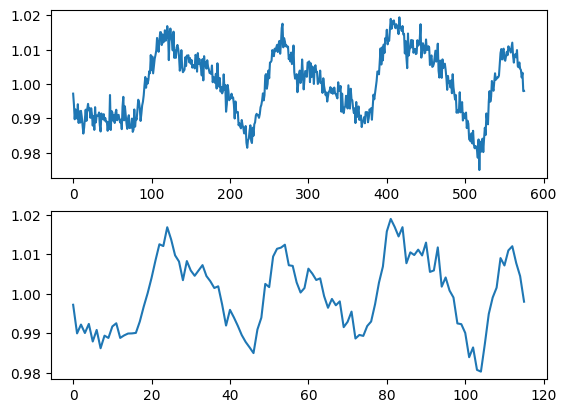

In [159]:
for sample_idx, (data, label, norm) in enumerate(train_data):
    print(sample_idx, data.shape)
    print(norm.shape)
#     plt.plot((norm*data)[1, 0])
    plt.subplot(2, 1, 1)
    plt.plot(data[1,0])
    
    reduced = reduce_resolution(data, 5)
    plt.subplot(2, 1, 2)
    plt.plot(reduced[1,0])
    break
    


In [154]:
np.set_printoptions(suppress=True)
for epoch in range(1, 2):
    train_on_sample(v, netD, train_data, nn.BCELoss(), opt, optimizerD, device, epoch)

ZeroDivisionError: division by zero

In [27]:
def rebuild_TS_one_shot(model, data, norm=None, batch_size=None):
    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    data = data.to(device)         
    x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
    
    model.train()
    for p in model.parameters():
        p.requires_grad = True
       
    return norm * x_rec

def adopt_weight(disc_factor, i, threshold, value=0.):
    if i < threshold:
        disc_factor = value
    return disc_factor

def train_adversial(model, desc, train_loader, criterion, optimizer, optimizerD, device, epoch):
    model.to(device)
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    desc.to(device)
    desc.train()
    for p in desc.parameters():
        p.requires_grad = True
    sample_loss = 0
    D_losses = []
    VQ_losses = []
    eps = 1e-10
    disc_factor = 1

    for sample_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device) 
        label = label[:,:,1].to(device)
        norm = norm.to(device)

#         print(data.shape)
#         print(label.shape)
#         print(norm.shape)
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
        
#         print(x_rec.shape)
       
        
        ## Train with all-real batch
        optimizerD.zero_grad()

        label_real = torch.full((data.size(0),), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        disc_real = netD(data).view(-1)
#         print("\nShapes of real data and their labels: \n")
#         print(data.shape, label_real.shape, disc_real.shape)
#         print(disc_real)
#         print(label_real)
        # Calculate loss on all-real batch
        errD_real = criterion(disc_real+ eps, label_real)
#         print("the error calculated is: ", errD_real)
        # Calculate gradients for D in backward pass
#         errD_real.backward(retain_graph=True)
        D_x = disc_real.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = rebuild_TS_one_shot(model, data, norm).to(device)
#         print(fake.device)
        label_fake = torch.full((fake.size(0),), fake_label, dtype=torch.float, device=device)
        
        # Classify all fake batch with D
        disc_fake = netD(fake.detach()).view(-1)
#         print("\nShapes of fake data and their labels: \n")
#         print(fake.shape, label_fake.shape, disc_fake.shape)
#         print(disc_fake)
#         print(label_fake)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(disc_fake + eps, label_fake)
#         print("the error calculated is: ", errD_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#         errD_fake.backward(retain_graph=True)
        D_G_z1 = disc_fake.mean().item()
        # Compute error of D as sum over the fake and the real batches
#         print("real error - fake error", errD_real.item(), errD_fake.item())
        errD = errD_real + errD_fake
#         errD.backward(retain_graph=True)
        # Update D
#         optimizerD.step()
        
        total_loss = loss + disc_factor * errD
        
        total_loss.backward()
        optimizer.step()
        optimizerD.step()   

        
#         loss = loss / 25
#         sample_loss = loss + errD.item()
        if sample_idx % 10 == 0:
            print("--------new Samples------------")
            print('Sample Epoch: {} [{}/{} ({:.0f}%)]\tLoss VQ: {:.6f}\t Loss Gan: {:.6f}'.format(
                epoch, sample_idx, len(train_loader),
                       100. * sample_idx / len(train_loader), loss, errD))
        D_losses.append(errD.item())
        VQ_losses.append(loss.item())
        
#     print('====> Sample: {} Average loss: {:.4f}'.format(epoch, sample_loss / len(train_loader.dataset)))
    
    ts_to_display = torch.randint(0, 100, (1,)).item()
    plt.clf()
    plt.plot((norm* data)[ts_to_display, 0].cpu())
    plt.plot((norm * x_rec)[ts_to_display,0].detach().cpu())
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
for epoch in range(1, 2):
    train_adversial(v, netD, train_data, nn.BCELoss(), opt, optimizerD, device, epoch)

In [279]:
def train_adversial2(model, desc, train_loader, criterion, optimizer, optimizerD, device, epoch):
    model.to(device)
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    desc.to(device)
    desc.train()
    for p in desc.parameters():
        p.requires_grad = True
    sample_loss = 0
    D_losses = []
    VQ_losses = []
    eps = 1e-10
    steps_per_epoch = len(train_loader)
    disc_factor = 1
    disc_start = 20000

    for sample_idx, (data, label, norm) in enumerate(train_loader):
        
        data = data.to(device) 
        label = label[:,:,1].to(device)
        norm = norm.to(device)
        norm_cpu = norm.detach().cpu() 
        
        x_rec, loss_rec, loss_e, mu, logvar, mu_rec, logvar_rec, e = model(data, split_loss=True)     
        
        # Reduce resolution of input and output
        fake_reduced = x_rec #reduce_resolution(x_rec, 5)
        real_reduced = data #reduce_resolution(data, 5)        
            
        # Pass through Descriminator
        disc_real = netD(real_reduced).squeeze()
        disc_fake = netD(fake_reduced).squeeze()
        
        disc_factor = adopt_weight(disc_factor, epoch*steps_per_epoch+sample_idx, threshold=disc_start)
        
        # Generate Labels
        label_real = torch.full((real_reduced.size(0),), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((fake_reduced.size(0),), fake_label, dtype=torch.float, device=device)
        
        # Get desc loss
        d_loss_real = criterion(disc_real + eps, label_real)
        d_loss_fake = criterion(disc_fake + eps, label_fake)
        
#         d_loss_real = torch.mean(F.relu(1. - disc_real ))
#         d_loss_fake = torch.mean(F.relu(1. + disc_fake))
#         print("loss real", d_loss_real.item())
#         print("loss fake",d_loss_fake.item())               
#         print(disc_fake.T)
        g_loss = torch.mean(1. - disc_fake)
#         print("g_loss", g_loss)

        
        λ = model.calculate_lambda(loss_rec, g_loss)
        
        gan_loss = disc_factor  * 0.5*(d_loss_real + d_loss_fake)

        vq_loss = loss_rec + loss_e + disc_factor * λ * g_loss
        
        optimizer.zero_grad()
        vq_loss.backward(retain_graph=True)

        optimizerD.zero_grad()
        gan_loss.backward()

        optimizer.step()
        if sample_idx % 200 ==0:
            optimizerD.step()
        
        D_losses.append(gan_loss.item())
        VQ_losses.append(vq_loss.item())
        
        if sample_idx % 20 == 0:
#             print("--------new Samples------------")
            print('Sample Epoch: {} [{}/{} ({:.0f}%)]\tLoss VQ: {:.6f}\tLoss Gan: {:.6f}\t\tScaling Facto: {:.6f}\tLoss g: {:.6f}'.format(
                epoch, sample_idx, len(train_loader),
                       100. * sample_idx / len(train_loader), vq_loss, gan_loss, λ, g_loss))
            print('\nLoss rec: {:.6f}\tLoss ema: {:.6f}\tLoss gan part in VQ: {:.6f}'.format(loss_rec, loss_e, disc_factor * λ * g_loss))
    display.clear_output(wait=True)
    ts_to_display = torch.randint(0, 40, (1,)).item()
    Origin = (norm* data)[ts_to_display, 0,:2000].cpu()
    REC = (norm * x_rec)[ts_to_display,0,:2000].detach().cpu()
    
#     if sampl_idx == 0:        
#         ts_to_display = torch.randint(0, 100, (1,)).item()
#         fig, ax = plt.subplots(figsize=(10, 5))
#         plt.clf()
#         plt.plot((norm* data)[ts_to_display, 0,:2000].cpu())
#         plt.plot((norm * x_rec)[ts_to_display,0,:2000].detach().cpu())
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#     else:
        
    return VQ_losses, D_losses, Origin, REC

In [280]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist

    # Compute the filter coefficients
    b, a = [0] * (order + 1), [0] * (order + 1)
    for i in range(order + 1):
        b[i] = comb(order, i) * (normal_cutoff ** i)
        a[i] = comb(order, i) * (normal_cutoff ** i)

    return b, a

def comb(n, k):
    """Compute the binomial coefficient C(n, k)."""
    from math import factorial
    return factorial(n) // (factorial(k) * factorial(n - k))

def apply_butter_lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)

    # Convert lists to PyTorch tensors
    b = torch.tensor(b, dtype=data.dtype)
    a = torch.tensor(a, dtype=data.dtype)

    # Transpose the data to ensure the last dimension is the one to be filtered
    data = data.transpose(-1, -2)

    # Initialize the filtered data tensor with zeros
    filtered_data = torch.zeros_like(data)

    # Apply the filter along the last dimension of the data using the ellipsis operator
    for i in range(data.shape[-1]):
        filtered_data[..., i] = nn.functional.lfilter(b, a, data[..., i])

    # Transpose the filtered data back to the original shape
    filtered_data = filtered_data.transpose(-1, -2)

    return filtered_data

    def denoise(ts):
    #     x_len = len(ts[0])
    #     noisy_signal = np.array(ts)
        noisy_signal = ts

        # Filter requirements.
        T = 7*24*60*60          # Sample Period
        fs = 1/(5)       # sample rate, Hz
        cutoff = 0.03      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
        nyq = 0.5 * fs  # Nyquist Frequency
        order = 2       # sin wave can be approx represented as quadratic
        n = int(T * fs) # total number of samples

        # Filter the data, and plot both the original and filtered signals.
        y = apply_butter_lowpass_filter(noisy_signal, cutoff, fs, order)

    #     plt.figure(figsize=(10, 6))
    #     plt.plot(noisy_signal.T, label='Noisy Signal')
    #     plt.plot(y.T, label='Filtered Signal')
    #     plt.xlabel('Time')
    #     plt.ylabel('Amplitude')
    #     plt.legend()
    #     plt.xlim(0,1000)
    #     plt.grid(True)
    #     plt.show()

        return y

In [291]:
def plot_rec(origin, rec, lines=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec, "r--", alpha = 0.5, label='Reconstruction')
    ax.plot(origin, "b-", alpha=0.2, label='Origin')
    
    ax.legend()
    ax.grid()
    plt.show()
    
def plot_losses(vq_loss, gan_loss, lines=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(vq_loss, "r--", alpha = 0.5)
    ax.plot(gan_loss, "b-", alpha=0.5)
#     plt.ylim(0,2000)
    
#     display.clear_output(wait=True)
    ax.grid()
    plt.show()

def reduce_resolution(data, factor):
    l = data.shape[-1]
    indices =  torch.arange(0, l, factor)
    results = data[..., indices]

    return results

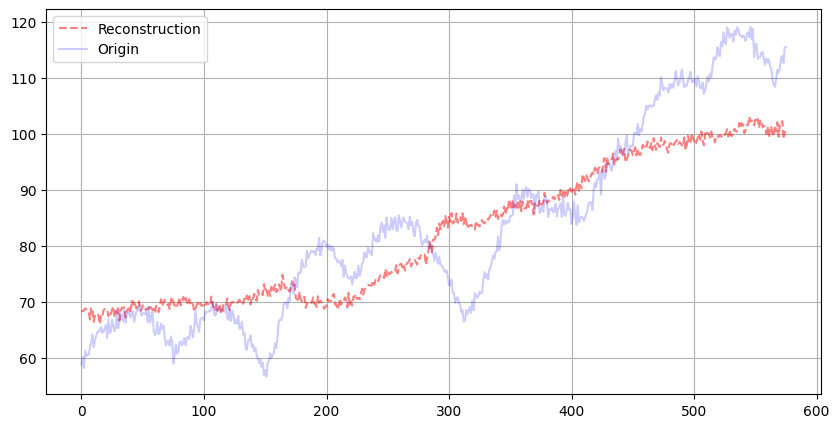

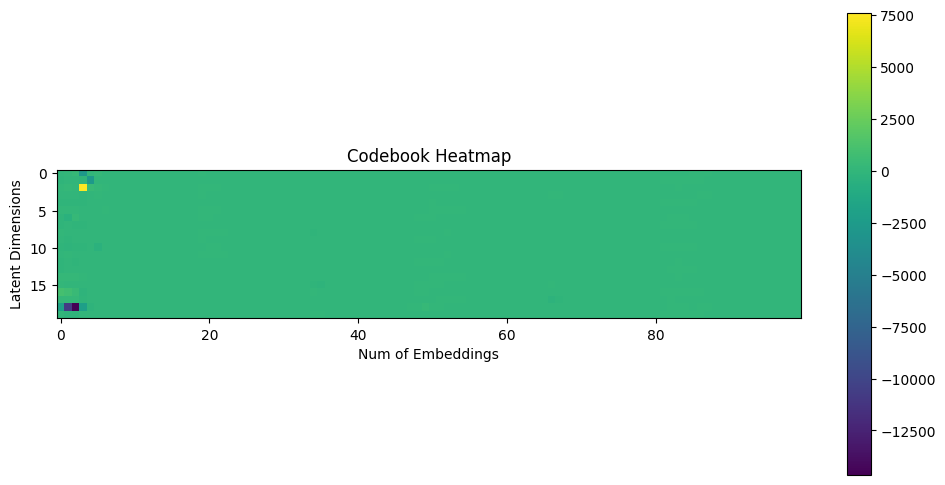

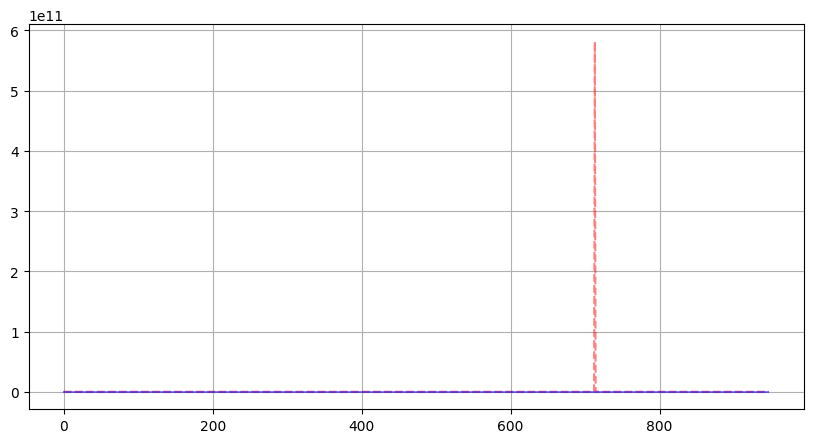

Sample Epoch: 948 [0/100 (0%)]	Loss VQ: 17236.328125	Loss Gan: 0.700454		Scaling Facto: 80.000000	Loss g: 0.507105

Loss rec: 16775.748047	Loss ema: 420.012024	Loss gan part in VQ: 40.568413
Sample Epoch: 948 [20/100 (20%)]	Loss VQ: 2274.553223	Loss Gan: 0.687325		Scaling Facto: 80.000000	Loss g: 0.508997

Loss rec: 1948.823120	Loss ema: 285.010315	Loss gan part in VQ: 40.719734
Sample Epoch: 948 [40/100 (40%)]	Loss VQ: 1290.259644	Loss Gan: 0.716326		Scaling Facto: 80.000000	Loss g: 0.496649

Loss rec: 662.894775	Loss ema: 587.632935	Loss gan part in VQ: 39.731907


KeyboardInterrupt: 

In [292]:
VQ_loss = []
GAN_loss = []
max_length = 2000
for epoch in range(1, 1000):
    vq_loss, gan_loss, origin, rec = train_adversial2(v, netD, train_data, nn.BCELoss(), opt, optimizerD, device, epoch)

    VQ_loss.append(np.mean(vq_loss))
    GAN_loss.append(np.mean(gan_loss))

    
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
        GAN_loss = GAN_loss[-max_length:]
#     print(VQ_loss)
#     print(GAN_loss)
    
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.plot(vq_loss, "r--", alpha = 0.5)
#     ax.plot(gan_loss, "b-", alpha=0.2)
    
#     if epoch == 0:
    plot_rec(origin, rec)
    codebook = v.quantizer._embedding.weight
    heatmap = create_heatmap(codebook.cpu().detach().numpy() )
    plot_losses(VQ_loss, GAN_loss)
    
    
    

In [ ]:
netD.train()
for p in netD.parameters():
    p.requires_grad = True
for sample_idx, (data, label, norm) in enumerate(train_data):
#         print(len(train_loader))

        data = data.to(device) 
        label = label[:,:,1].to(device)
        norm = norm.to(device)
        
        
#         print(data.shape)
        prob = netD(data)
        print(prob.item())
#         print(label.shape)
#         print(norm.shape)

        
        data_loader = DataLoader(slidingWindow((data*norm).squeeze(0), L=2016), # slidingWindow, stridedWindow
                            batch_size= 50,# 59, # 22
                            shuffle = False
                            )
# #         for indx_new, (data_new, label_new, norm_new) in enumerate(data_loader):
# #             print(data_new.shape)
# #             print(norm_new.shape)
# #             print(indx_new)
        
#         loss = 0
#         for sample_epoch in range(2):
#             for batch_idx, (data_n, _, norm) in enumerate(data_loader):
#                 prob = netD(data_n)


In [ ]:
3529*2 + 1008

In [185]:
8064 - 1008

7056

In [201]:
55*8


440

In [30]:
torch.randint(0, 100, (1,)).item()

69